[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code here follows the [TensorFlow](https://www.tensorflow.org/) implementation by Mark Chang found [here](https://github.com/ckmarkoh/neuralart_tensorflow).

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
from skimage.transform import resize
from tensorflow.python.framework import ops
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vggmodelfile = 'imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(os.path.join('.', vggmodelfile)):
    import six.moves.urllib.request as request
    # use `dl=1` as part of query to force a download
    origin = ('https://www.dropbox.com/s/qy9gikdpuq95w8n/%s?dl=1' % vggmodelfile)
    print('Downloading VGG16 model from: %s' % origin)
    request.urlretrieve(origin, vggmodelfile)
else:
    print('VGG19 model', vggmodelfile, 'is available.')

VGG19 model imagenet-vgg-verydeep-19.mat is available.


In [3]:
out_dir = './results'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [120]:
image_dir = './images'
source_image = 'MALcloudGate2560x1600.jpg'
style_image = 'impressionist.jpg'

source = os.path.join(image_dir, source_image)
style = os.path.join(image_dir, style_image)

if os.path.isdir(image_dir):
    print('Image directory is ready...')
else:
    os.makedirs(image_dir)
        
if os.path.exists(source):
    print('Source image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/9cosz20ijl4xerm/%s?dl=1' % source_image)
    print('Downloading source image from: %s' % origin)
    request.urlretrieve(origin, source)

if os.path.exists(style):
    print('Style image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/8frdjcgf7vnjosx/%s?dl=1' % style_image)
    print('Downloading style image from: %s' % origin)
    request.urlretrieve(origin, style)

Image directory is ready...
Source image exists...
Style image exists...


In [121]:
# some global vars for training
INI_NOISE_RATIO = 0.7
STYLE_STRENGTH = 500
ITERATION = 100

In [122]:
def imshow_clean(img, interpolation=None):
    fig = plt.figure()
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(img, interpolation=interpolation)
    return im

0 255
(1600, 2560, 3)


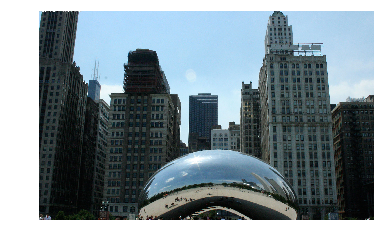

In [123]:
source_data = plt.imread(source)
imshow_clean(source_data)
print(np.min(source_data), np.max(source_data))
print(source_data.shape)

0 255
(1200, 1920, 3)


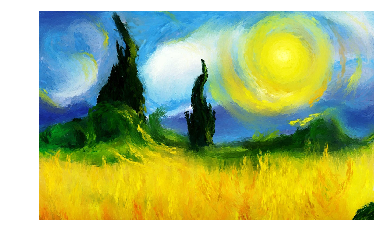

In [124]:
style_data = plt.imread(style)
imshow_clean(style_data)
print(np.min(style_data), np.max(style_data))
print(style_data.shape)

In TensorFlow, image tensor shapes should be : `N x H x W x NChannels`. We will be using a pre-trained VGG16 model here, so we need to resize our images appropriately. In order to use the VGG model, we will also need to subtract the mean of the training dataset for that model.

In [125]:
IMAGE_W = 800   # 1.333 aspect ratio
IMAGE_H = 600
VGG_MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

(1200, 1600, 3)
[28 28 29 29 30 29 29 29 28 29]


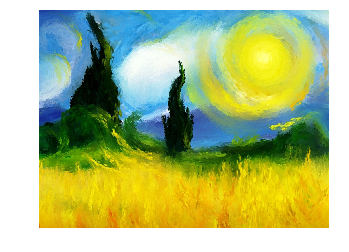

In [130]:
style_clipped = style_data[:,160:1760,:]   # 1200 * 1.333 ~ 1600, take center clip
print(style_clipped.shape)
print(style_clipped[0:10,0,0])
imshow_clean(style_clipped)

If you have to `resize` an image, the elements are re-scaled into the range $[0, 1]$. Be careful to scale back to 0 to 255.

(1, 600, 800, 3)
[ 28.25  29.25  29.5   29.25  28.25  34.    37.    36.    31.    35.75]


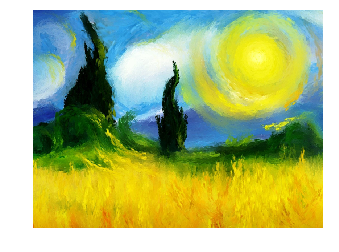

In [132]:
style_resized = 255. * resize(style_clipped, (IMAGE_H, IMAGE_W, 3))
# we need to use a 4-tensor
style_resized = np.reshape(style_resized, (1, IMAGE_H, IMAGE_W, 3))
print(np.shape(style_resized))
print(style_resized[0,0:10,0,0])
imshow_clean(style_resized[0].astype('uint8'))

-123.0 151.0


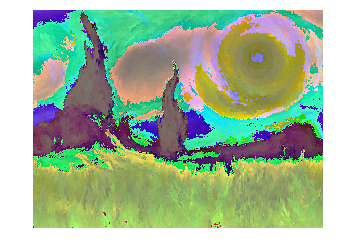

In [136]:
style_normalized = style_resized - VGG_MEAN_VALUES
print(np.min(style_normalized), np.max(style_normalized))
imshow_clean(style_normalized[0].astype('int8'))

0.0 255.0


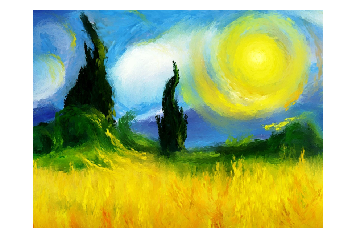

In [137]:
print(np.min(style_normalized + VGG_MEAN_VALUES), np.max(style_normalized + VGG_MEAN_VALUES))
imshow_clean((style_normalized + VGG_MEAN_VALUES)[0].astype('uint8'))

(1600, 2132, 3)
[ 41  16  20  17  22  20  10  57 175 247]


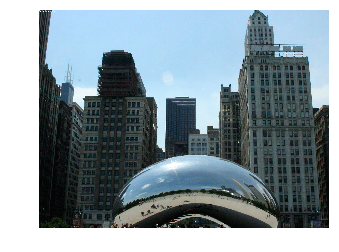

In [139]:
source_clipped = source_data[:,214:2346,:]    # 1600 * 1.333 ~ 2132, take center clip
print(source_clipped.shape)
print(source_clipped[0:10,0,0])
imshow_clean(source_clipped)

(1, 600, 800, 3)
[  16.28166667   26.9925      211.94458333  112.6225       47.12875
   55.69708333   59.005        58.84         64.83666667   67.665     ]


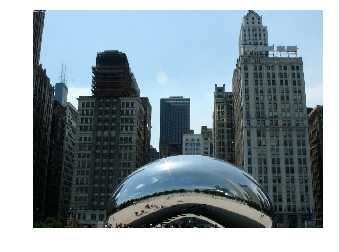

In [141]:
source_resized = 255. * resize(source_clipped, (IMAGE_H, IMAGE_W, 3))
# we need to use a 4-tensor
source_resized = np.reshape(source_resized, (1, IMAGE_H, IMAGE_W, 3))
print(np.shape(source_resized))
print(source_resized[0,0:10,0,0])
imshow_clean(source_resized[0].astype('uint8'))

-123.0 151.0


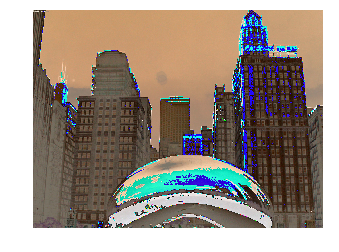

In [142]:
source_normalized = source_resized - VGG_MEAN_VALUES
print(np.min(source_normalized), np.max(source_normalized))
imshow_clean(source_normalized[0].astype('int8'))

0.0 255.0


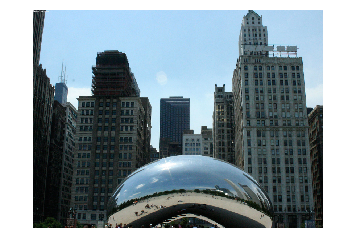

In [143]:
print(np.min(source_normalized + VGG_MEAN_VALUES), np.max(source_normalized + VGG_MEAN_VALUES))
imshow_clean((source_normalized + VGG_MEAN_VALUES)[0].astype('uint8'))

In [144]:
# rename for convenience / simplicity
source_img = source_normalized
style_img = style_normalized

In [145]:
CONTENT_LAYERS = [('conv4_2', 1.)]
STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.), ('conv4_1', 1.), ('conv5_1', 1.)]

In [146]:
def build_net(ntype, nin, rwb=None):
    """
    utility function for building network layers
    * ntype == network layer type
    * nin == network input layer
    """
    # `strides` basically describe how far the kernel steps in each tensor dimension
    # `ksize` describes the size of the pooling region
    # If we use `SAME` padding, the filter is allowed to go off the edge by half the filter size on each side,
    # so we would expect an unchanged image size with stride=1 and a (1/2)x(1/2) for stride=2.
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, rwb[0], strides=[1, 1, 1, 1], padding='SAME') + rwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Padding is explained in the TF [documentation for convolution](https://www.tensorflow.org/api_docs/python/nn/convolution#convolution). 

Let's demonstrate it with the pooling operation:

In [147]:
# X shape of None x 6 x 6 x 1 -> any number of 6x6 tensors that are "1-deep" (e.g., grayscale)
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

TensorFlow separates graph definition and computation into two steps - we must execute operations within a _Session_.

In [148]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We need to pass a tensor with actual data into our "graph" to see how it works.

In [149]:
X_vals = np.arange(6*6).reshape(1, 6, 6, 1)
print(X_vals)

[[[[ 0]
   [ 1]
   [ 2]
   [ 3]
   [ 4]
   [ 5]]

  [[ 6]
   [ 7]
   [ 8]
   [ 9]
   [10]
   [11]]

  [[12]
   [13]
   [14]
   [15]
   [16]
   [17]]

  [[18]
   [19]
   [20]
   [21]
   [22]
   [23]]

  [[24]
   [25]
   [26]
   [27]
   [28]
   [29]]

  [[30]
   [31]
   [32]
   [33]
   [34]
   [35]]]]


In [150]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [151]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [152]:
ops.reset_default_graph()

<img src='./poolig_examp.png'>

Let's look at a different stride to see if the pooling ops behave differently:

In [153]:
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')

In [154]:
# we are using the default graph, so we have to re-initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [155]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 6, 6, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]
   [  8. ]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]
   [ 14. ]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]
   [ 20. ]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]
   [ 26. ]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]
   [ 32. ]]

  [[ 30.5]
   [ 31.5]
   [ 32.5]
   [ 33.5]
   [ 34.5]
   [ 35. ]]]]


In [156]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 5, 5, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]]]]


Ok, with that demo over, let's reset the graph. Before we do, we can inspect it:

In [157]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'AvgPool', 'AvgPool_1', 'init']

In [158]:
ops.reset_default_graph()

In [159]:
[op.name for op in tf.get_default_graph().get_operations()]

[]

In [160]:
def get_weight_bias(vgg_layers, i):
    """
    utility function to get weights and bias values from the layers of our pre-built vgg19 model;
    we set the weights as `constant` to indicate they should not be trainable.
    """
    weights = vgg_layers[i][0][0][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias

In [161]:
def build_vgg19(path):
    """
    build the VGG DNN
    """
    net = {}
    vgg_rawnet = scipy.io.loadmat(path)
    vgg_layers = vgg_rawnet['layers'][0]
    net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
    net['conv1_1'] = build_net('conv', net['input'], get_weight_bias(vgg_layers, 0))
    net['conv1_2'] = build_net('conv', net['conv1_1'], get_weight_bias(vgg_layers, 2))
    net['pool1'] = build_net('pool', net['conv1_2'])
    net['conv2_1'] = build_net('conv', net['pool1'], get_weight_bias(vgg_layers, 5))
    net['conv2_2'] = build_net('conv', net['conv2_1'], get_weight_bias(vgg_layers, 7))
    net['pool2'] = build_net('pool', net['conv2_2'])
    net['conv3_1'] = build_net('conv', net['pool2'], get_weight_bias(vgg_layers, 10))
    net['conv3_2'] = build_net('conv', net['conv3_1'], get_weight_bias(vgg_layers, 12))
    net['conv3_3'] = build_net('conv', net['conv3_2'], get_weight_bias(vgg_layers, 14))
    net['conv3_4'] = build_net('conv', net['conv3_3'], get_weight_bias(vgg_layers, 16))
    net['pool3'] = build_net('pool', net['conv3_4'])
    net['conv4_1'] = build_net('conv', net['pool3'], get_weight_bias(vgg_layers, 19))
    net['conv4_2'] = build_net('conv', net['conv4_1'], get_weight_bias(vgg_layers, 21))
    net['conv4_3'] = build_net('conv', net['conv4_2'], get_weight_bias(vgg_layers, 23))
    net['conv4_4'] = build_net('conv', net['conv4_3'], get_weight_bias(vgg_layers, 25))
    net['pool4'] = build_net('pool', net['conv4_4'])
    net['conv5_1'] = build_net('conv', net['pool4'], get_weight_bias(vgg_layers, 28))
    net['conv5_2'] = build_net('conv', net['conv5_1'], get_weight_bias(vgg_layers, 30))
    net['conv5_3'] = build_net('conv', net['conv5_2'], get_weight_bias(vgg_layers, 32))
    net['conv5_4'] = build_net('conv', net['conv5_3'], get_weight_bias(vgg_layers, 34))
    net['pool5'] = build_net('pool', net['conv5_4'])
    return net

In [162]:
def gram_matrix(x, area, depth):
    """
    input/evaluate with TF tensors
    """
    x1 = tf.reshape(x, (area, depth))
    g = tf.matmul(tf.transpose(x1), x1)
    return g

In [163]:
def gram_matrix_val(x, area, depth):
    """
    numpy version of the `gram_matrix` method (may be evaluated outside a TF `Session`)
    """
    x1 = x.reshape(area, depth)
    g = np.dot(x1.T, x1)
    return g

In [164]:
def build_content_loss(p, x):
    M = p.shape[1] * p.shape[2]
    N = p.shape[3]
    loss = (1. / (2 * N**0.5 * M**0.5)) * tf.reduce_sum(tf.pow((x - p), 2))
    return loss

In [165]:
def build_style_loss(a, x):
    M = a.shape[1] * a.shape[2]
    N = a.shape[3]
    A = gram_matrix_val(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1. / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

Now, with helper functions set, let's perform the style transfer.

In [166]:
net = build_vgg19(vggmodelfile)

In [167]:
[op.name for op in tf.get_default_graph().get_operations()]

['Variable/initial_value',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'Const',
 'Const_1',
 'Conv2D',
 'add',
 'Relu',
 'Const_2',
 'Const_3',
 'Conv2D_1',
 'add_1',
 'Relu_1',
 'AvgPool',
 'Const_4',
 'Const_5',
 'Conv2D_2',
 'add_2',
 'Relu_2',
 'Const_6',
 'Const_7',
 'Conv2D_3',
 'add_3',
 'Relu_3',
 'AvgPool_1',
 'Const_8',
 'Const_9',
 'Conv2D_4',
 'add_4',
 'Relu_4',
 'Const_10',
 'Const_11',
 'Conv2D_5',
 'add_5',
 'Relu_5',
 'Const_12',
 'Const_13',
 'Conv2D_6',
 'add_6',
 'Relu_6',
 'Const_14',
 'Const_15',
 'Conv2D_7',
 'add_7',
 'Relu_7',
 'AvgPool_2',
 'Const_16',
 'Const_17',
 'Conv2D_8',
 'add_8',
 'Relu_8',
 'Const_18',
 'Const_19',
 'Conv2D_9',
 'add_9',
 'Relu_9',
 'Const_20',
 'Const_21',
 'Conv2D_10',
 'add_10',
 'Relu_10',
 'Const_22',
 'Const_23',
 'Conv2D_11',
 'add_11',
 'Relu_11',
 'AvgPool_3',
 'Const_24',
 'Const_25',
 'Conv2D_12',
 'add_12',
 'Relu_12',
 'Const_26',
 'Const_27',
 'Conv2D_13',
 'add_13',
 'Relu_13',
 'Const_28',
 'Const_29',
 'Conv2D

In [168]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [169]:
noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')

In [170]:
sess.run([net['input'].assign(source_img)])
cost_source = sum(
    map(lambda l,: l[1] * build_content_loss(sess.run(net[l[0]]), net[l[0]]), CONTENT_LAYERS)
)

In [171]:
sess.run([net['input'].assign(style_img)])
cost_style = sum(
    map(lambda l,: l[1] * build_style_loss(sess.run(net[l[0]]), net[l[0]]), STYLE_LAYERS)
)

In [172]:
STYLE_STRENGTH = 250

In [173]:
cost_total = cost_source + STYLE_STRENGTH * cost_style
optimizer = tf.train.AdamOptimizer(learning_rate=2.0)
train = optimizer.minimize(cost_total)

In [174]:
print(np.min(1. * source_img), np.max(1. * source_img))

-123.0 151.0


noise image :  -20.0 20.0
source image:  -123.0 151.0
src+vgg img :  0.0 255.0
combo image :  -50.7833593674 59.2925603867
cmb+vgg img :  59.1477869263 176.598428345


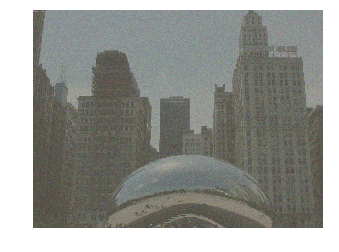

In [179]:
INI_NOISE_RATIO = 0.7
initial_img = INI_NOISE_RATIO * noise_img + (1. - INI_NOISE_RATIO) * source_img
print('noise image : ', np.min(noise_img), np.max(noise_img))
print('source image: ', np.min(source_img), np.max(source_img))
print('src+vgg img : ', np.min(source_img + VGG_MEAN_VALUES), np.max(source_img + VGG_MEAN_VALUES))
print('combo image : ', np.min(initial_img[0]), np.max(initial_img[0]))
print('cmb+vgg img : ', np.min((initial_img + VGG_MEAN_VALUES)[0]), np.max((initial_img + VGG_MEAN_VALUES)[0]))
imshow_clean((initial_img + VGG_MEAN_VALUES)[0].astype('uint8'))

In [180]:
sess.run(tf.initialize_all_variables())
sess.run(net['input'].assign(initial_img))

array([[[[-33.77581787, -31.61005402, -13.35669804],
         [-27.39866638, -33.46260452, -10.21654224],
         [-19.94300652,  -5.48019314,  -3.76056051],
         ..., 
         [ 11.14022923,  33.40914536,  40.89599228],
         [  9.44114113,  36.46505356,  42.09819412],
         [ 22.85453796,  31.16826248,  53.24441528]],

        [[-20.5050354 , -24.36156654, -14.98135948],
         [ 10.70965576,  21.72370148,  31.20733643],
         [ -7.186409  , -20.48565674, -11.73123646],
         ..., 
         [ 15.45771503,  18.3964901 ,  39.43157959],
         [  3.55372596,  38.47875595,  40.48016739],
         [  4.81951475,  32.18634033,  51.42215729]],

        [[ 35.75870895,  30.74462318,  46.57355881],
         [ 15.54539776,  14.79365635,  14.42421818],
         [ -3.71799731, -22.53886986, -21.67870712],
         ..., 
         [  3.56139922,  25.14111519,  34.3596611 ],
         [ 25.49927711,  17.44950294,  52.15460587],
         [ 15.27060604,  40.53002167,  29.13631821

In [181]:
sess.run(train)

(1, 600, 800, 3)
-52.7296 61.2926
57.2365608215 178.545490265


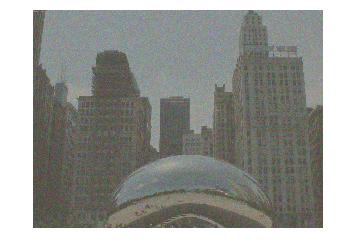

In [182]:
result_image = sess.run(net['input'])
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

In [183]:
for i in range(10):
    print(i)
    sess.run(train)
    result_image = sess.run(net['input'])
    print(sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

0
5.73342e+11
55.2947425842 180.465084076
1
5.26396e+11
53.437084198 182.350318909
2
4.83092e+11
51.4248466492 184.255065918
3
4.44205e+11
49.4093513489 186.197647095
4
4.1023e+11
47.3862228394 188.140213013
5
3.8091e+11
45.3670425415 190.114028931
6
3.5539e+11
43.3532142639 192.101356506
7
3.32768e+11
41.3558044434 194.011978149
8
3.12764e+11
39.3597183228 195.618301392
9
2.95539e+11
37.3090667725 197.553237915


(1, 600, 800, 3)
-72.4397 81.0926
37.3090667725 197.553237915


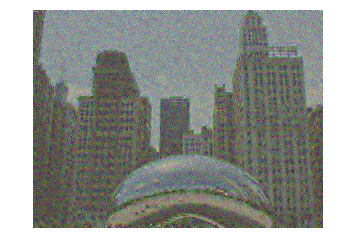

In [184]:
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 